## Timeseries Anomaly Detection
- What is timeseries?
    - A series of data points arranged chronologically, usually at equally spaced intervals.
-  Time series data is widespread in weather, finance, medicine, engineering
- Examples: daily temperatures, stock prices, heart rate, power grid voltage

![unnamed-chunk-4-1](https://github.com/surajkarki66/shortIT/assets/50628520/35ce0c50-0d50-4b39-9beb-49dad3684dc9)


**What is anomaly in Time series data?**
- Time is special feature as it provides a natural ordering of the data.
- Nature does not make jumps.
- Furthermore, when looking at time series data we expect changes to be gradual. This assumption of temporal continuity is often used to detect anomalies in time series.
- Anomaly = sudden change in data values
    - Can be a jump at a single value or change in trend

**Types of Data for Timeseries Anomaly Detection**
1. Offline: You have all the data you are interested in
    -  For any point, you can use information from the past, present and future
2. Streaming: all you know are the present and the past
    -  To detect anomalies, you often have to predict the future and compare the new data with your prediction(see weather forecasting)

**Methods of Detecting Anomaly in Timeseries Data**
1. Statistical Process Control
2. Autoregressive Models

### Implementation

## Imports

In [32]:
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
import statsmodels as ss
import statsmodels.api as sm


from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

%matplotlib inline

## Python and library versions

In [2]:
packages = [matplotlib, np, pd]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]

library .      version
-------        -------
matplotlib       3.7.2
numpy           1.23.5
pandas           2.0.3


## Section 1: Statistical Process Control
- Statistical methods used to monitor a process
- It is actually the quality control of the data.
- Anomaly occurs when the observed data surpasses the predefined threshold for a particular statistical parameter.
- Often carried out through visual display of the data: control charts
- Here, we mainly used two sets of statistics
    - Mean and Standard Deviation
    - Cumulative Sum

**A. Control Chart: Mean and Standard Deviation**
- Consider a time series of N data points: xi (temperature at time point i=1,2,...N)
- You have to decide a particular data point is anomaly or not based on a threshold z.
- Have to calculate the mean and standard deviation of that particular timeseries.
- A point is marked as anomaly if:  

$$
\frac{{\lvert x_i - \mu \rvert}}{{\sigma}} > z
$$

**Pros of Control Chart**
- Simple to implement
- Easy to interpret
- Sensitive to point anomalies
- Can be used in both offline mode and with streaming data
- If underlying distribution is known, can relate threshold to probability of observing the event.

**Cons of Control Chart**
- To use this method, you need good guesses for the average and the spread of the data, and it's best if these guesses come from clean, normal data.
- Be aware that this approach might mistakenly label things as anomaly when they're not because, given enough time, even rare events can occur.
- Cannot adapt to changing trend

### Data

In [4]:
df_ppt = pd.read_csv('nyc_precipitation_oct2018.csv', parse_dates=True, index_col=0)
df_ppt.head(10)

/tmp/ipykernel_2391/3175570593.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ppt = pd.read_csv('nyc_precipitation_oct2018.csv', parse_dates=True, index_col=0)


Precipitation
Date                     
2018-10-01           0.00
2018-10-02           0.33
2018-10-03           0.00
2018-10-04           0.04
2018-10-05           0.00
2018-10-06           0.00
2018-10-07           0.00
2018-10-08           0.00
2018-10-09           0.00
2018-10-10           0.00

Lets visualize the dataset

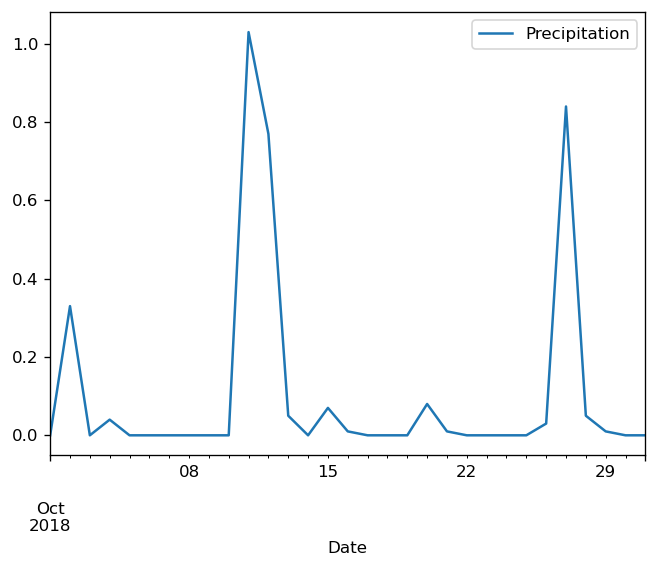

In [5]:
plt.figure(dpi=120)
df_ppt.plot(ax=plt.gca())
plt.show();

In [6]:
df_ppt.describe()

Precipitation
count      31.000000
mean        0.107097
std         0.266573
min         0.000000
25%         0.000000
50%         0.000000
75%         0.045000
max         1.030000

Due to the many days without precipitation, the mean and standard deviation are fairly small, but the large maximum value suggest there is at least one anomalous point.

We can see from the summary statistics and the plot that any anomalies will be above the mean, which is 0.107 in, so we need only a one-sided control plot.  

There is another way to reach the same conclusion. Since the precipitation cannot be a negative number, all possible values below the mean lie in the range 0 <= precipitation <= 0.107 in.), which are within one standard deviation (0.267 in.) of the mean and therefore not anomalies. 

In [7]:
def control_plot(time_series, threshold):
    '''
    Creates a one-sided control plot from a time series
    (that is, plots threshold above the mean but not below)
    Also, returns list of points that exceed the threshold
    i.e., points for which the value > mean + threshold*(standard deviation)
    
    Args: 
        time_series: (pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        threshold: z-score threshold for anomaly detection (float)

    Returns: 
        Control plot of time_series    
        anomalies: anomalies that exceed threshold (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    cutoff = mean_+threshold*stdev_
    plt.figure(dpi=140)
    time_series.plot(ax=plt.gca())
    plt.axhline(y=mean_, color='g', linestyle='--', label='mean')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=cutoff, color='r', linestyle=':', label='threshold')
    plt.legend(loc='best')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    
    # Create dataframe of anomalies that exceed the cutoff
    anomalies = time_series[time_series.values > cutoff]
    return anomalies

Set a threshold of 3 standard deviations and plot the results.

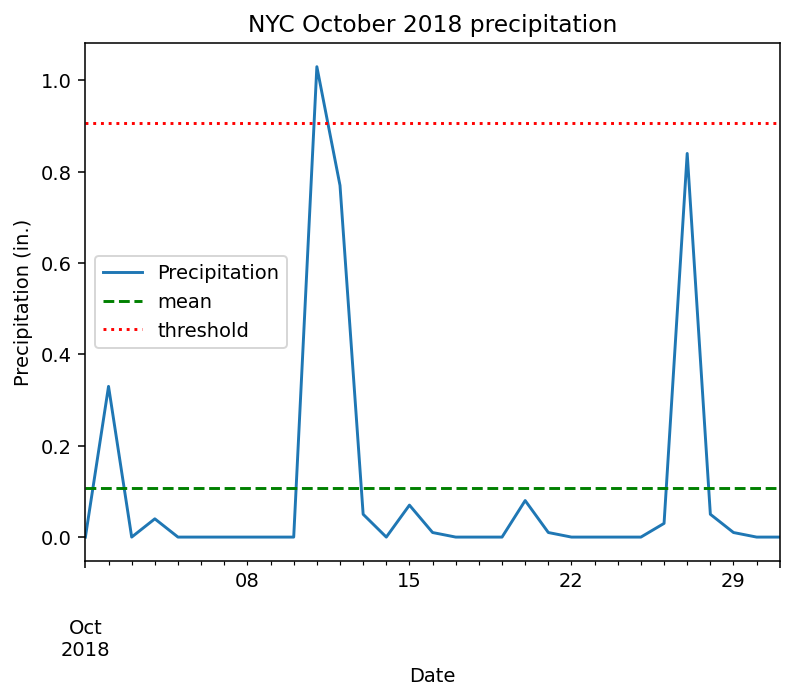

In [8]:
anomaly_ppt = control_plot(df_ppt, 3)

There's an anomaly. Get the data for this point. 

In [9]:
print(anomaly_ppt)

            Precipitation
Date                     
2018-10-11           1.03


**B. Control Chart: Cumulative Sum**
- Calculate the cumulative sum of the values in the time series.
- When the cumulative sum exceeds a threshold, a change has been found
- Can detect changes missed by standard control chart (based on z-score)


**Algorithm**
- Track the cumulative sums of the positive deviation from the mean (“the high sum”) and the negative deviation from the mean (“the low sum”)
- Consider the time series described previously:
    - xi with i=1,2,...N
    - mean μ and standard deviation σ
- Denote size of the shift to be registered by λ
- Denote threshold by w 

**The high sum**
- Given by following recursive sequence: $$S_i^+ = \max(0, S_{i-1}^+ + (x_i - \mu - \lambda))$$
- The initial condition is $$S_i^+ = 0$$
- Anomaly if:  $$S_i^+ > w$$


**The low sum**
- Given by following recursive sequence: $$S_i^+ = \min(0, S_{i-1}^+ + (x_i - \mu - \lambda))$$
- The initial condition is $$S_i^+ = 0$$
- Anomaly if:  $$S_i^+ < -w$$

In [10]:
def cusum(data, mean, shift, threshold):
    '''
    Calculate the high and low cumulative sums and use these for anomaly detection. 
    An anomaly is reported if the cumulative sums are beyong a given threshold.
    
    Args: 
        data: (a time series as pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        mean:  mean of the data or other average (float)
        shift: normal shift in the data; standard deviation is recommend (float)
        threshold: threshold to classify point as anomaly (float)

    Returns: 
        cusum: the high and low cumulative sums together with data (pandas dataframe)  
        anomalies: anomalies that above and below threshold (pandas dataframe)
    ''' 
    high_sum = 0.0
    low_sum = 0.0
    anomalies = [] 
    high_sum_final = []
    low_sum_final = []
    index_names = data.index
    data_values = data.values
    for index, item in enumerate(data_values):
        high_sum = max(0, high_sum + item - mean - shift)
        low_sum = min(0, low_sum + item - mean + shift)
        high_sum_final.append(high_sum)
        low_sum_final.append(low_sum)
        if high_sum > threshold or low_sum < -threshold:
            anomalies.append((index_names[index], item.tolist()))
    cusum = data
    cusum = cusum.assign(High_Cusum=high_sum_final, Low_Cusum=low_sum_final)
    return cusum, anomalies

In [13]:
def cusum_plot(time_series, threshold):
    '''
    Plot the high and low cumulative sums and use these for anomaly detection. 
    An anomaly is reported if the cumulative sums are beyong a given threshold.
    
    Args: 
        time_series: (a time series as pandas dataframe; index column is date 
        in datetime format and column 0 is data)
        threshold: threshold to classify point as anomaly (float)

    Returns: 
        A plot of the data with the high cumulative sum.
        cusum_results: the high and low cumulative sums together with data 
        and any anomalies that above and below threshold (pandas dataframe; 
        from cumsum function)
    ''' 
    # Use the mean and standard deviation of the whole time series 
    # to calculate cumulative sums
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    
    # define threshold in terms of standard deviation
    cusum_results = cusum(time_series, mean_, stdev_, threshold*stdev_)
    ax=time_series.plot()
    ax.axhline(y=mean_, color='g', linestyle='--',label='average')
    ax.axhline(y=mean_+threshold*stdev_, color='r', linestyle='--',label='High threshold')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    ax.scatter(x=cusum_results[0].index, y=cusum_results[0]['High_Cusum'], 
             color='k', linestyle=':',label='High Cusum')
    ax.scatter(x=cusum_results[0].index, y=cusum_results[0]['Low_Cusum'], 
             color='y', linestyle=':',label='Low Cusum') 
    plt.legend(loc='center left')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    return cusum_results

Choice of threshold: for the control chart, we used 3 times the standard deviation. Note that the equivalent threshold for CUSUM is *threshold*=2 since CUSUM includes the *shift* (which we chose to be one standard deviation) in its calculation of the cumulative sum. 

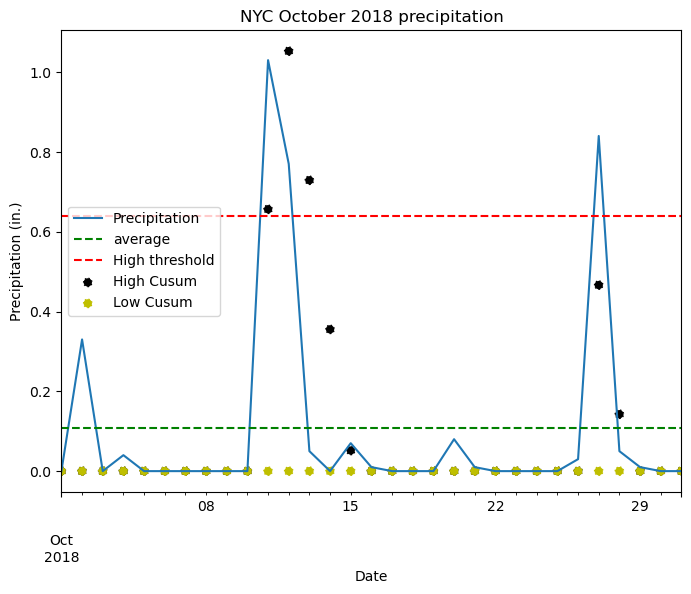

In [14]:
cusum_plot(df_ppt, 2);

Note that CUSUM finds the same anomaly as the control chart (1.03 inches on October 11, 2018), but it also labels the two successive points as anomalies. Why? 

The different results reflect the difference in the algorithms. The control chart is looking for single, anomalous points. CUSUM is sensitive to change in the behavior of the data. As a result, it flags points as anomalous until the behavior of the time series has returned to normal. 

Indeed, CUSUM is used for change point detection: finding when the underlying distribution of the time series has changed. 


**A final comment.**  We used all of the data to compute the baseline statistics (mean and standard deviation) for the anomaly detection. While this approach is sometimes used, the presence of anomalies in the data can bias these baseline statistics. A more rigorous approach is to select data that is considered normal, use that data to calculate the baseline statistics and only then detect the anomalies.  We will explore this idea in Exercise 1.

## Section 2: Autogressive models
- Detecting anomalies through modeling.
- Idea: make a model to predict the value of the data at a given time
- Compare the predicted value with the actual value
- If the difference exceeds a threshold, label the point as an anomaly
- Here we use autoregressive models
    - Present value depends on past values
- Autoregressive models are commonly used for streaming anomaly detection

### Data

In [15]:
df_nyc_temp = pd.read_csv('nyc_daily_temp_final.csv', parse_dates=True, index_col=0)

In [18]:
df_nyc_temp

TMAX  TMIN
DATE                  
1959-02-01    24    15
1959-02-02    26     9
1959-02-03    38    19
1959-02-04    44    38
1959-02-05    46    36
...          ...   ...
2018-10-27    58    43
2018-10-28    54    46
2018-10-29    58    47
2018-10-30    57    43
2018-10-31    63    38

[21823 rows x 2 columns]

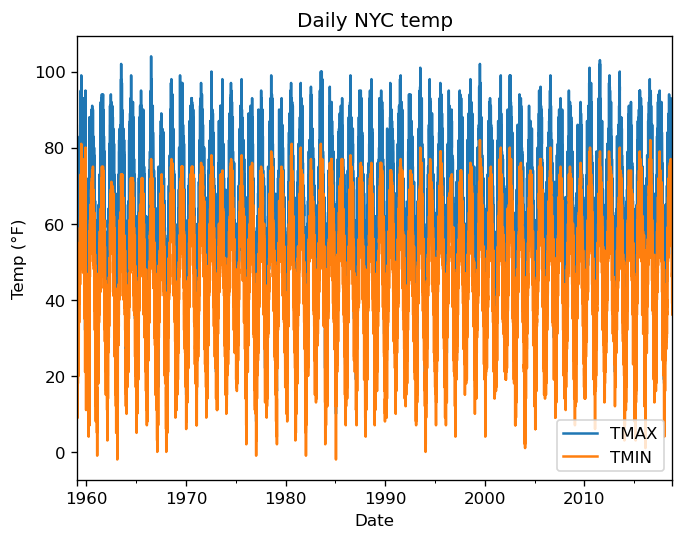

In [16]:
plt.figure(dpi=120)
df_nyc_temp.plot(ax=plt.gca())
plt.title('Daily NYC temp')
plt.xlabel('Date')
plt.ylabel('Temp (°F)')
plt.show()


Not easy to see whether there are anomalies with so many points. Let's look at the statistics for both TMAX (the maximum daily temperature) and TMIN (the minimum daily temperature). 

In [17]:
df_nyc_temp.describe()

TMAX          TMIN
count  21823.000000  21823.000000
mean      61.548091     47.129496
std       17.585690     16.468738
min        8.000000     -2.000000
25%       48.000000     34.000000
50%       62.000000     47.000000
75%       77.000000     62.000000
max      104.000000     82.000000

The highest value of TMAX (104 °F) and the lowest value of TMIN (-2 °F) are quite extreme. But are these anomalies?
And what about the anomalies we seeded into the dates with missing values?

For Dec. 1, 1959, TMAX and TMIN are 40 °F *warmer* than what a linear interpolation would predict.

In [19]:
df_nyc_temp.loc['1959-11-30':'1959-12-02']

TMAX  TMIN
DATE                  
1959-11-30    38    26
1959-12-01    95    80
1959-12-02    51    33

For May 1, 1960, TMAX and TMIN are 40°F *colder* than what a linear interpolation would predict.

In [20]:
df_nyc_temp.loc['1960-4-30':'1960-5-02']

TMAX  TMIN
DATE                  
1960-04-30    60    50
1960-05-01    22     7
1960-05-02    64    43

Will we detect these points as anomalies?

#### Modeling
We will use an autoregressive model to detect anomalies. Here we will look at TMAX and leave TMIN for Exercise 2. 
We start by creating a dataframe of just TMAX

In [21]:
df_nyc_tmax=df_nyc_temp[['TMAX']]

In [22]:
df_nyc_tmax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21823 entries, 1959-02-01 to 2018-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TMAX    21823 non-null  int64
dtypes: int64(1)
memory usage: 857.0 KB


In [23]:
df_nyc_tmax.head()

TMAX
DATE            
1959-02-01    24
1959-02-02    26
1959-02-03    38
1959-02-04    44
1959-02-05    46

In [24]:
def control_plot_full(time_series, threshold):
    '''
    Creates a two-sided control plot from a time series
    (plots threshold above and below the mean)
    Also, returns list of points that exceed the threshold
    i.e., points for which the value > mean + threshold*(standard deviation) 
    and value < mean - threshold*(standard deviation)
    
    Args: 
        time_series: (pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        threshold: threshold for anomaly detection (float)

    Returns: 
        Control plot of time_series    
        anomalies: anomalies that exceed threshold (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:, 0].mean()
    stdev_= time_series.iloc[:, 0].std()
    time_series.plot()
    plt.axhline(y=mean_, color='g', linestyle='--',label='average')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=mean_+threshold*stdev_, color='r', linestyle=':', label='high threshold')
    plt.axhline(y=mean_-threshold*stdev_, color='m', linestyle=':', label='low threshold')
    plt.legend(loc='upper right')
    plt.title('NYC Temperature')
    plt.ylabel('Temp (F)')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    # Create dataframe of anomalies that exceed the threshold
    anomaly_mask = (np.abs(time_series.values - mean_) > threshold*stdev_)
    anomalies = time_series[anomaly_mask]
    return anomalies

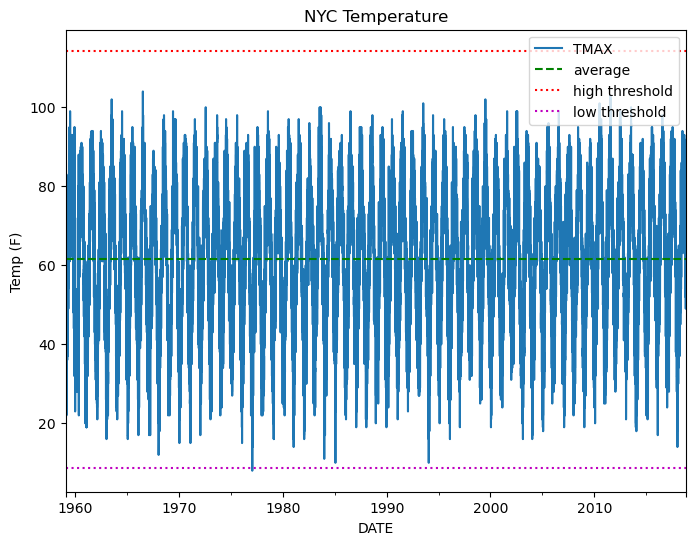

In [26]:
a = control_plot_full(df_nyc_tmax, 3)

In [27]:
print(a)

            TMAX
DATE            
1977-01-17     8


**Note_1**: It can take a significant amount of work to find a successful autoregression model and we do not claim that the model presented here is optimal.The parameters were chosen to have a reasonable runtime.

**Note_2**: There are models that explicit incorporate _seasonal effects_ while modeling, such as the statsmodels SARIMAX function. The length of a full cycle cannot be too long for the series to converge, so yearly seasons don't work well on daily data (each season is 365 data points). A more sophisticated treatment, such as doing a Fourier Analysis and then subtracting off the annual component would typically be done in this case. 

**Note_3**: The autoregression models in python require that the time series analyzed have an appropriate date frequency, which is why it is important to check for missing values as a pre-processing step. If the time_series is complete, many packages that deal with time_series can infer the frequency, even if it isn't supplied.

In [28]:
print(df_nyc_tmax.index.inferred_freq)

D


Daily frequency. That's good! Let's make it explicit!

In [29]:
df_nyc_temp.index.freq=df_nyc_tmax.index.inferred_freq

And now to fit our data with the model.

In [33]:
tmax_sar=ARIMA(df_nyc_tmax, order=(1,1,4)).fit()
tmax_sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TMAX   No. Observations:                21823
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -71865.154
Date:                Mon, 05 Feb 2024   AIC                         143742.307
Time:                        22:53:18   BIC                         143790.251
Sample:                    02-01-1959   HQIC                        143757.927
                         - 10-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0868      0.163      0.534      0.593      -0.232       0.405
ma.L1         -0.4544      0.162     -2.797      0.005      -0.773      -0.136
ma.L2         -0.2280      0.061     -3.768      0.000      -0.347      -0.109
ma.L3         -0.0528      0.044     -1.195      0.232      -0.139       0.034
ma.L4         -0.0310      0.016     -1.884      0.060      -0.063       0.001
sigma2        42.4612      0.336    126.411      0.000      41.803      43.120
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               855.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.04
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We check the diagnostics to check that the assumptions underlying the model are met and also for additional information on the quality of the fit.  This is done using a Q-Q plot (checking that the residuals follow a normal distribution), investigating the residuals for temporal patterns, and plotting a histogram of the residuals

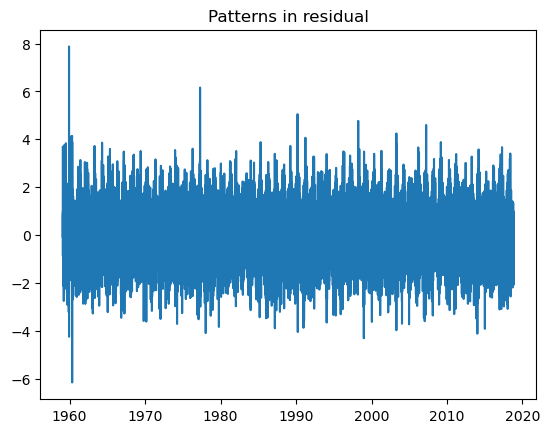

In [34]:
# Get the predicted standard deviation. This is the 6.516 we saw earlier
sigma_pred = tmax_sar.resid.std()

# Calculate the standardized residuals from the (regular) residuals
tmax_std_resid = tmax_sar.resid/sigma_pred

plt.title('Patterns in residual')
plt.plot(tmax_std_resid);

In [42]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plt.title('Distribution of residuals')
sns.histplot(tmax_std_resid.values, bins=50, ax=ax);
stats.probplot(tmax_std_resid.values, dist='norm', sparams=(2.5,), plot=plt.subplot(122));

For anomaly detection, we focus on the top plot: standardized residuals. The standardized residual is the residual (the difference between the observed value and the predicted value) divided by the predicted standard deviation (the square root of the predicted variance we mentioned above). 

A rule of thumb for detecting anomalies with standardized residuals: anomalies are points for which the magnitude of the standardized residals is greater than 4. Let's find these points. 

In [43]:
# Report the anomalies
anomaly_mask = np.abs(tmax_std_resid) > 4
tmax_anomalies = tmax_std_resid[anomaly_mask]
print(tmax_anomalies)

DATE
1959-12-01    7.878599
1959-12-02   -4.251382
1960-03-28    4.139199
1960-04-25    4.132208
1960-05-01   -6.161220
1977-04-12    6.162723
1978-01-10   -4.096459
1990-03-13    5.050174
1990-03-24   -4.052199
1991-03-28    4.064322
1998-03-27    4.770194
1998-03-29    4.051903
1998-12-23   -4.312631
2003-04-16    4.244040
2007-03-27    4.598190
2014-01-07   -4.120865
dtype: float64


Our model found both of the seeded anomalies (Dec. 1, 1959 and May 1, 1960). 

The model did not find the lone anomaly detected by the control plot (January 17, 1977), but it did find several others that were not picked up by the control plot. 

The next step would be to vary the parameters of the autoregression model and check how robust these findings are, but as that belongs to the realm of time series analysis, we will stop here.

### Exercise #1

This exercise refers to Section 1 (statistical process control). 

A. Choose a subset of the precipitation data that you consider anomaly-free (for example, the first 10 days). Use this data to calculate the mean and standard deviation.

B. Repeat the control chart analysis.

C. Compare the anomalies you find with those found previously.

### Solution #1

In [44]:
df_ppt = pd.read_csv('nyc_precipitation_oct2018.csv', parse_dates=True, index_col=0)
df_ppt_10 = df_ppt[:10]
df_ppt_10.shape

/tmp/ipykernel_2391/580965156.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_ppt = pd.read_csv('nyc_precipitation_oct2018.csv', parse_dates=True, index_col=0)


(10, 1)

In [45]:
mean = df_ppt_10.iloc[:,0].mean()
stdev_ = df_ppt_10.iloc[:,0].std()

In [48]:
def control_plot_modified(time_series, mean_, stdev_, threshold):
    '''
    Creates a one-sided control plot from a time series
    (that is, plots threshold above the mean but not below)
    Also, returns list of points that exceed the threshold
    i.e., points for which the value > mean + threshold*(standard deviation)
    
    Args: 
        time_series: (pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        threshold: z-score threshold for anomaly detection (float)

    Returns: 
        Control plot of time_series    
        anomalies: anomalies that exceed threshold (pandas dataframe)
    ''' 

    cutoff = mean_+threshold*stdev_
    plt.figure(dpi=140)
    time_series.plot(ax=plt.gca())
    plt.axhline(y=mean_, color='g', linestyle='--', label='mean')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=cutoff, color='r', linestyle=':', label='threshold')
    plt.legend(loc='best')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    
    # Create dataframe of anomalies that exceed the cutoff
    anomalies = time_series[time_series.values > cutoff]
    return anomalies

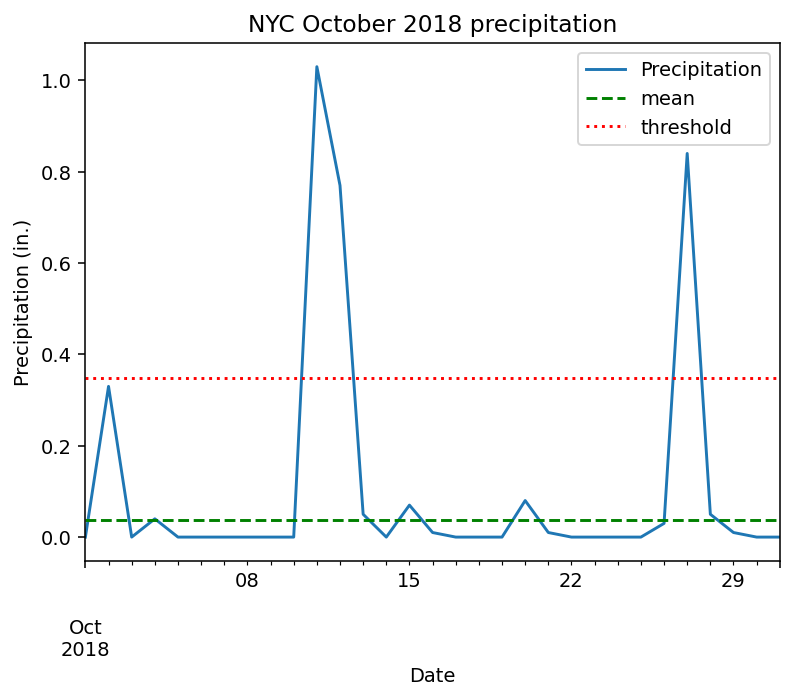

In [49]:
a = control_plot_modified(df_ppt, mean, stdev_, 3)

In [50]:
print(a)

            Precipitation
Date                     
2018-10-11           1.03
2018-10-12           0.77
2018-10-27           0.84


### Exercise #2

This exercise refers to Section 2 (autogression models). 

A. Repeat the analysis for the TMIN values. 

B. Do you find the same anomalies as TMAX?

### Solution #2


In [51]:
df_nyc_tmin=df_nyc_temp[['TMIN']]

In [52]:
df_nyc_tmin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21823 entries, 1959-02-01 to 2018-10-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TMIN    21823 non-null  int64
dtypes: int64(1)
memory usage: 857.0 KB


In [53]:
df_nyc_tmin.head()

TMIN
DATE            
1959-02-01    15
1959-02-02     9
1959-02-03    19
1959-02-04    38
1959-02-05    36

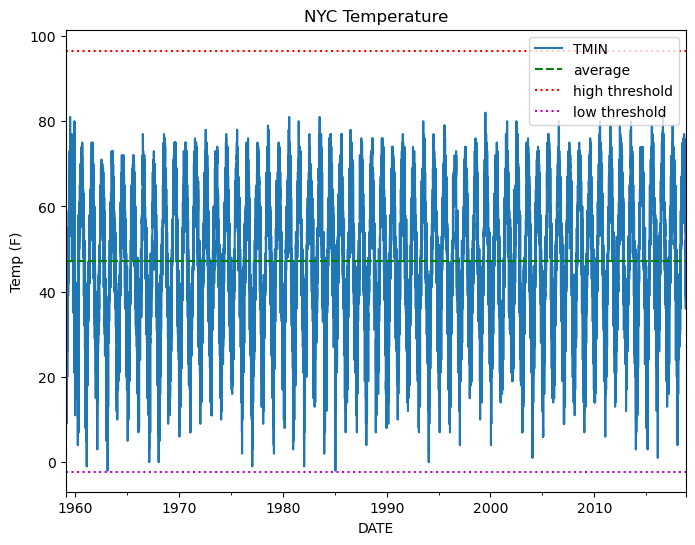

In [54]:
a = control_plot_full(df_nyc_tmin, 3)

In [55]:
print(a)

Empty DataFrame
Columns: [TMIN]
Index: []


In [57]:
print(df_nyc_tmin.index.inferred_freq)

D


In [58]:
tmin_sar=ARIMA(df_nyc_tmin, order=(1,1,4)).fit()
tmin_sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TMIN   No. Observations:                21823
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -66158.877
Date:                Mon, 05 Feb 2024   AIC                         132329.754
Time:                        23:20:23   BIC                         132377.698
Sample:                    02-01-1959   HQIC                        132345.373
                         - 10-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1053      0.150      0.700      0.484      -0.189       0.400
ma.L1         -0.2804      0.150     -1.864      0.062      -0.575       0.014
ma.L2         -0.3046      0.028    -11.005      0.000      -0.359      -0.250
ma.L3         -0.1063      0.051     -2.098      0.036      -0.206      -0.007
ma.L4         -0.0239      0.024     -1.005      0.315      -0.070       0.023
sigma2        25.1689      0.185    136.210      0.000      24.807      25.531
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3372.48
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# Get the predicted standard deviation. This is the 6.516 we saw earlier
sigma_pred = tmin_sar.resid.std()

# Calculate the standardized residuals from the (regular) residuals
tmin_std_resid = tmin_sar.resid/sigma_pred

plt.title('Patterns in residual')
plt.plot(tmin_std_resid);

In [60]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plt.title('Distribution of residuals')
sns.histplot(tmin_std_resid.values, bins=50, ax=ax);
stats.probplot(tmin_std_resid.values, dist='norm', sparams=(2.5,), plot=plt.subplot(122));

In [61]:
# Report the anomalies
anomaly_mask = np.abs(tmin_std_resid) > 4
tmin_anomalies = tmin_std_resid[anomaly_mask]
print(tmin_anomalies)

DATE
1959-02-19   -4.063896
1959-12-01    9.956677
1959-12-02   -8.112039
1960-03-27    4.664693
1960-05-01   -8.378458
1960-05-02    5.825295
1963-02-08   -5.550023
1964-12-18   -4.060989
1965-12-26   -4.320911
1973-02-16   -4.564309
1976-02-02   -4.738842
1980-12-25   -4.118439
1982-11-05   -4.123185
1982-12-09   -4.865789
1985-01-20   -4.042370
1989-02-14    4.157576
1989-09-23   -4.203152
1991-01-21   -4.319398
1993-02-01   -4.710663
1994-01-28    5.346446
1995-02-05   -4.551278
1996-02-20    4.101945
2003-03-03   -4.006762
2003-10-22   -4.003410
2003-10-26    4.358417
2004-01-09   -4.064144
2016-01-04   -4.465001
2016-02-16    4.147752
dtype: float64
